In [5]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [26]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [9]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [12]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [13]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [14]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [27]:
# Find the most recent date in the data set.
# Use of inspector to find column names for each table to use later in the queries
inspector = inspect(engine)
measurement_columns = inspector.get_columns("measurement")
for c in measurement_columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [28]:
inspector = inspect(engine)
station_columns = inspector.get_columns("station")
for c in station_columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [35]:
# The most recent date in the data set.
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"{latest[0]}")

2017-08-23


In [45]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

latest_date = dt.datetime.strptime(latest[0], '%Y-%m-%d')
query_start_date = dt.date(latest_date.year -1, latest_date.month, latest_date.day)
print(query_start_date)

2016-08-23


In [60]:
# Perform a query to retrieve the data and precipitation scores

prcp_scores = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-23').\
    order_by(Measurement.date).all()
#prcp_scores

In [61]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_scores_df = pd.DataFrame(prcp_scores,columns=['Date','Precipitation'])
prcp_scores_df = prcp_scores_df.dropna(how='any') # clean up non value entries
prcp_scores_df = prcp_scores_df.set_index("Date")

# Sort the dataframe by date
prcp_scores_df=prcp_scores_df.sort_values(["Date"], ascending=True)
prcp_scores_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


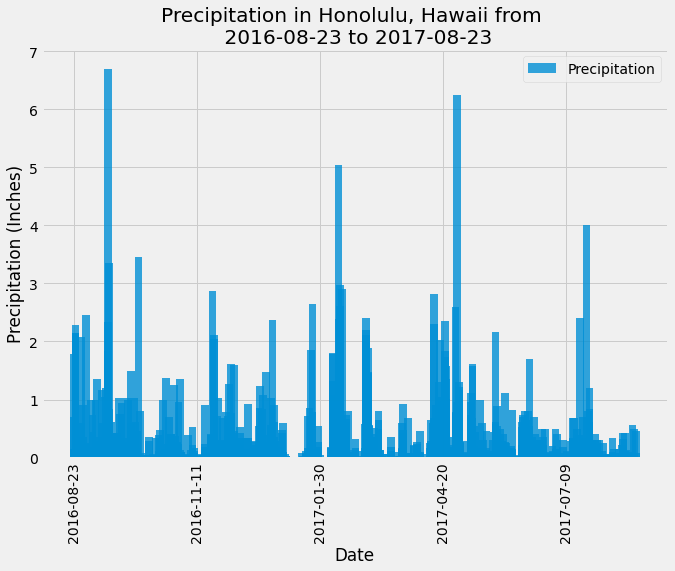

In [94]:
# Use Pandas Plotting with Matplotlib to plot the data
# Set plot size and plot the chart
plt.figure(figsize=(10,7))
xx = prcp_scores_df.index.tolist()
yy = prcp_scores_df['Precipitation'].tolist()

# Plot format 
plt.bar(xx,yy,width = 5 , alpha=0.8, align="center",label='Precipitation')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are on
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks, rotation=90)

plt.title(f"Precipitation in Honolulu, Hawaii from \n {query_start_date} to {latest[0]}")
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()

# Save Figure
plt.savefig("Images/Precipitation_Plot.png", bbox_inches = 'tight')
# Show plot
plt.show()


In [64]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_scores_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [69]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.id).count()

9

In [70]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sta = [Station.station, func.count(Measurement.station)]
session.query(*sta).filter(Station.station == Measurement.station).group_by(Station.station).\
                            order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [76]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#stl = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
#session.query(*stl).filter(Measurement.station == sta[0]).all()
#[(53.0, 87.0, 73.09795396419437)]

stl = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
most_active_station_data = session.query(*stl).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
most_active_station_data
#[(54.0, 85.0, 71.66378066378067)]

(54.0, 85.0, 71.66378066378067)

In [82]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Choose the station with the highest number of temperature observations.
session.query(Measurement.station, func.count(Measurement.tobs)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.tobs).desc()).first() # 'USC00519281'


('USC00519281', 2772)

In [85]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_values = session.query(Measurement.tobs).\
            filter(Measurement.date>=query_start_date,\
                   Measurement.station == 'USC00519281').all()

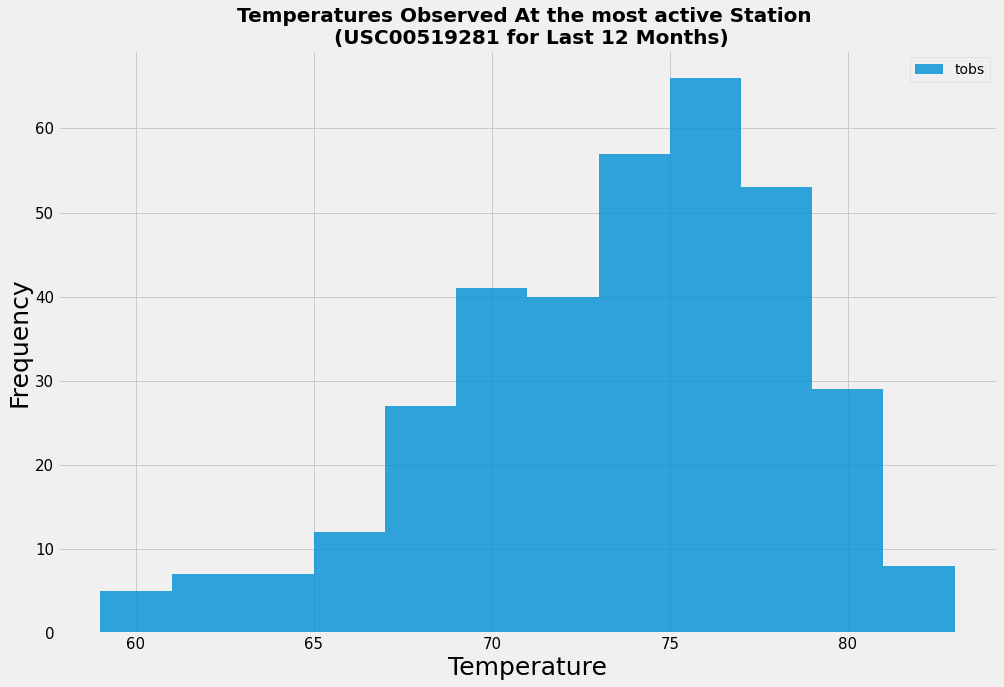

<Figure size 432x288 with 0 Axes>

In [96]:
# Plot the results as a histogram
plt.figure(figsize=(15,10))
plt.hist(np.ravel(tobs_values), bins=12,alpha=0.8, align="mid")
plt.title("Temperatures Observed At the most active Station \n (USC00519281 for Last 12 Months)", fontsize=20, fontweight = 'bold')
plt.xlabel('Temperature',fontsize=25)
plt.ylabel('Frequency',fontsize=25)
plt.legend(['tobs'], loc = 'upper right')
plt.yticks(size=15)
plt.xticks(size=15)

# Save Figure
plt.savefig("Images/station_Plot.png")
# Show plot
plt.show()
plt.tight_layout()


# Close Session

In [90]:
# Close Session
session.close()